This notebook plots the solutions. You can actually plot the progress while the solver is running to see if it makes sense.

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

import numpy as np
from setup import resultsname
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
import matplotlib as mpl
from setup import domain

In [2]:
t = np.load('./'+resultsname+'/t.npy')
nodes_x = np.load('./'+resultsname+'/nodes_x.npy')
nodes_y = np.load('./'+resultsname+'/nodes_y.npy')

In [3]:
# create map from parallel dof numbering to serial dof numbering
nodes = np.column_stack((nodes_x,nodes_y))
nodes_target = domain.geometry.x[:,0:2]
inds = np.abs(nodes-nodes_target)<1 
inds = inds[:,0]*inds[:,1]
mismatch = np.where(inds==False)[0]
map_dofs = np.arange(nodes_x.size)
for j in mismatch:
   map_dofs[j] = np.where( (np.abs(nodes_x[:] - nodes_target[j,0])<1)&(np.abs(nodes_y[:] - nodes_target[j,1])<1) )[0]

In [4]:
# load results and reorder dof's to the serial ordering
N = np.load('./'+resultsname+'/N.npy')[:,map_dofs]
b = np.load('./'+resultsname+'/b.npy')[:,map_dofs]
qx = np.load('./'+resultsname+'/qx.npy')[:,map_dofs]
qy = np.load('./'+resultsname+'/qy.npy')[:,map_dofs]
storage = np.load('./'+resultsname+'/storage.npy')[:,map_dofs]

# get water flow speed
q_m = np.sqrt(qx**2+qy**2)

In [5]:
# create triangulation for matplotlib plotting that mirrors the mesh triangulation.
triang = Triangulation(domain.geometry.x[:,0]/1e3,domain.geometry.x[:,1]/1e3,domain.geometry.dofmap)

In [6]:
# get mean of N over the lake and max of q not over the lake
N_mean = np.zeros(t.size)
q_max = np.zeros(t.size)

j_max=0

for j in range(t.size):
    if np.max(q_m[j,:]>1e-7):
        N_j = N[j,:]
        N_mean[j] = np.mean(N_j[storage[j,:]>1e-2])

        q_j = q_m[j,:]
        q_max[j] = np.max(q_j[storage[j,:]<1e-2])
        j_max+=1 
j_max -= 1

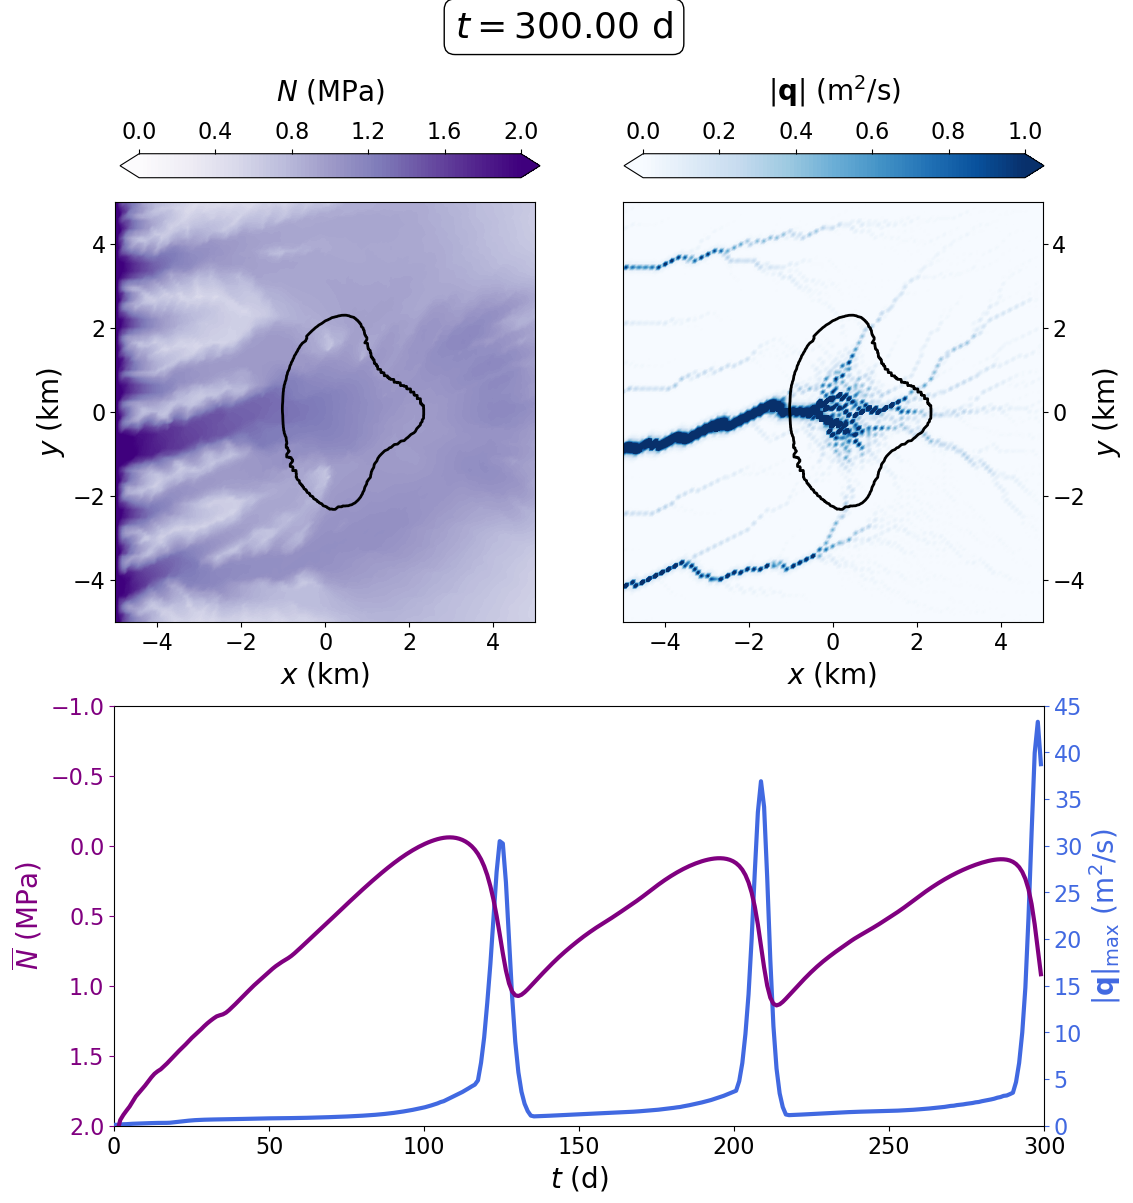

In [11]:
# choose to plot a single timestep OR a sequence to make a movie
ind = [j_max]               # plot a single time step
#ind = np.arange(0,j_max,1) # plot every time step for saving a movie


!rm -r movie_{resultsname}
!mkdir movie_{resultsname}

j=0

if len(ind)>1:
# use agg backend for saving pngs
    mpl.use('agg')
else:
    %matplotlib inline

for i in ind:
    print('saved image '+str(j+1)+' out of '+str(len(ind))+' \r',end='')
    
    fig = plt.figure(figsize=(12,12))
            
    plt.suptitle(r'$t=$'+'{:.2f}'.format(365*t[i]/3.154e7)+' d',y=1.04,fontsize=26,bbox=dict(boxstyle='round', facecolor='w', alpha=1))

    plt.subplot(221)
    N_i = N[i]
    storage_i = storage[i]
    p1 = plt.tricontourf(triang,N_i/1e6,levels=np.linspace(0,2,100),cmap='Purples',extend='both')
    plt.tricontour(triang,storage_i,levels=[0.001],colors='k',linestyles='-',linewidths=2)
    # plt.triplot(triang.x, triang.y, triang.triangles,linewidth=1,color='k',alpha=0.1)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$x$ (km)',fontsize=20)
    plt.ylabel(r'$y$ (km)',fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar_ax = fig.add_axes([0.13, 0.9, 0.35, 0.02])
    cbar = plt.colorbar(p1,orientation='horizontal',ticks=np.linspace(0,2,6),cax=cbar_ax)
    cbar.set_label(r'$N$ (MPa)',fontsize=20,labelpad=15)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    
    plt.subplot(222)
    q_i = q_m[i]
    p2 = plt.tricontourf(triang,q_i,cmap='Blues',levels=np.linspace(0,1,100),extend='both')
    plt.tricontour(triang,storage_i,levels=[0.001],colors='k',linestyles='-',linewidths=2)
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel(r'$x$ (km)',fontsize=20)
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.ylabel(r'$y$ (km)',fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar_ax = fig.add_axes([0.55, 0.9, 0.35, 0.02])
    cbar = plt.colorbar(p2,orientation='horizontal',ticks=np.linspace(0,1,6),cax=cbar_ax)
    cbar.set_label(r'$|\mathbf{q}|$ (m$^2/$s)',fontsize=20,labelpad=15)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    
    plot = plt.subplot(212)
    ax2 = plt.gca()
    plt.plot(t[0:i]*365./3.154e7,N_mean[0:i]/1e6,color='purple',linestyle='-',linewidth=3,zorder=100)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', colors="purple")
    plt.ylabel(r'$\overline{N}$ (MPa)',fontsize=20,color='purple')
    plt.ylim(np.floor(N_mean.max()/1e6),np.floor(N_mean.min()/1e6))
    plt.xlabel(r'$t$ (d)',fontsize=20)
    plt.xlim(0,t[j_max]*365./3.154e7)

    plt.gca().twinx()
    plt.plot(t[0:i]*365./3.154e7,q_max[0:i],color='royalblue',linewidth=3,zorder=10)
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()   
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().tick_params(axis='y', colors="royalblue")
    plt.ylabel(r'$|\mathbf{q}|_\mathrm{max}$ (m$^2$/s) ',fontsize=20,color='royalblue')
    plt.xlabel(r'$t$ (d)',fontsize=20)
    plt.xlim(0,t[j_max]*365./3.154e7)
    plt.ylim(0,np.ceil(q_max.max())+1)

    plot.set_zorder(ax2.get_zorder()+1)
    plot.set_frame_on(False)
    plt.savefig('./movie_'+resultsname+'/'+str(j),bbox_inches='tight')
    if len(ind)==1:
        plt.show()
    plt.close()
    j+=1